# Defect Classifier


In [55]:
import os, cv2, numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers
import xml.etree.ElementTree as ET


In [56]:
DATA = Path('/Users/willekjellberg/.cache/kagglehub/datasets/zhangyunsheng/defects-class-and-location/versions/1')
CLASSES = ['crease', 'crescent_gap', 'inclusion', 'oil_spot', 'punching_hole', 'rolled_pit', 'silk_spot']

def load(path):
    img = cv2.imread(str(path), 0)
    if img is None: return None, None
    
    # Location from XML
    xml = DATA / 'label/label' / (path.stem + '.xml')
    loc = np.array([0.5, 0.5, 0.5, 0.5], np.float32)
    if xml.exists():
        try:
            root = ET.parse(xml).getroot()
            w, h = float(root.find('.//width').text), float(root.find('.//height').text)
            box = root.find('.//bndbox')
            xmin, ymin = float(box.find('xmin').text)/w, float(box.find('ymin').text)/h
            xmax, ymax = float(box.find('xmax').text)/w, float(box.find('ymax').text)/h
            loc = np.array([(xmin+xmax)/2, (ymin+ymax)/2, xmax-xmin, ymax-ymin], np.float32)
        except: pass
    
    # Preprocess
    mask = img > 10
    if mask.any():
        r, c = np.where(mask)
        img = img[r.min():r.max()+1, c.min():c.max()+1]
    img = cv2.resize(img, (128, 128))
    img = cv2.createCLAHE(2.5, (8,8)).apply(img).astype(np.float32) / 255.0
    return img[..., None], loc


In [57]:
# Load
X_img, X_loc, y = [], [], []
for i, cls in enumerate(CLASSES):
    for p in (DATA / 'images/images' / cls).glob('*.jpg'):
        img, loc = load(p)
        if img is not None:
            X_img.append(img); X_loc.append(loc); y.append(i)

X_img, X_loc, y = np.array(X_img), np.array(X_loc), np.array(y)
X_img_train, X_img_test, X_loc_train, X_loc_test, y_train, y_test = train_test_split(
    X_img, X_loc, y, test_size=0.2, random_state=42, stratify=y)

# Balanced class weights with sqrt scaling
counts = np.bincount(y_train)
class_weights = {i: np.sqrt(len(y_train)/(len(CLASSES)*c)) for i,c in enumerate(counts)}
print(f"Loaded {len(y)} images. Class distribution: {dict(zip(CLASSES, counts))}")


Loaded 1598 images. Class distribution: {'crease': np.int64(41), 'crescent_gap': np.int64(181), 'inclusion': np.int64(173), 'oil_spot': np.int64(163), 'punching_hole': np.int64(175), 'rolled_pit': np.int64(25), 'silk_spot': np.int64(520)}


In [58]:
# Model
img_in = layers.Input((128,128,1), name='image')
loc_in = layers.Input((4,), name='location')

# Augmentation
x = layers.RandomRotation(.1)(img_in)
x = layers.RandomTranslation(.1,.1)(x)
x = layers.RandomFlip('horizontal')(x)

# Simpler CNN with gradual growth
x = layers.Conv2D(48, 5, strides=2, padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Dropout(.2)(x)

x = layers.Conv2D(96, 3, strides=2, padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Dropout(.2)(x)

x = layers.Conv2D(192, 3, strides=2, padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Dropout(.3)(x)

x = layers.Conv2D(384, 3, padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(.4)(x)

# Location
loc = layers.BatchNormalization()(loc_in)
loc = layers.Dense(48, 'relu')(loc)

# Fusion
x = layers.Concatenate()([x, loc])
x = layers.Dense(256, 'relu', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(x)
x = layers.Dropout(.5)(x)

model = tf.keras.Model([img_in, loc_in], layers.Dense(len(CLASSES), 'softmax')(x))
model.compile(tf.keras.optimizers.Adam(1e-3), 'sparse_categorical_crossentropy', metrics=['accuracy'])


In [59]:
# Train
train = tf.data.Dataset.from_tensor_slices(({'image': X_img_train, 'location': X_loc_train}, y_train)).shuffle(512).batch(24).prefetch(2)
val = tf.data.Dataset.from_tensor_slices(({'image': X_img_test, 'location': X_loc_test}, y_test)).batch(24).prefetch(2)

model.fit(train, validation_data=val, epochs=int(os.getenv("EPOCHS", "80")), class_weight=class_weights, verbose=2,
    callbacks=[tf.keras.callbacks.EarlyStopping('val_accuracy', 30, restore_best_weights=True, mode='max', start_from_epoch=10),
               tf.keras.callbacks.ReduceLROnPlateau('val_accuracy', .5, 12, min_lr=1e-6, mode='max')])


Epoch 1/80
54/54 - 13s - 245ms/step - accuracy: 0.4053 - loss: 1.8857 - val_accuracy: 0.4062 - val_loss: 1.6903 - learning_rate: 0.0010
Epoch 2/80
54/54 - 3s - 56ms/step - accuracy: 0.4867 - loss: 1.6654 - val_accuracy: 0.4062 - val_loss: 1.7130 - learning_rate: 0.0010
Epoch 3/80
54/54 - 3s - 56ms/step - accuracy: 0.4844 - loss: 1.6344 - val_accuracy: 0.4094 - val_loss: 1.7170 - learning_rate: 0.0010
Epoch 4/80
54/54 - 3s - 56ms/step - accuracy: 0.4930 - loss: 1.5896 - val_accuracy: 0.4187 - val_loss: 1.5964 - learning_rate: 0.0010
Epoch 5/80
54/54 - 3s - 54ms/step - accuracy: 0.5188 - loss: 1.6368 - val_accuracy: 0.4594 - val_loss: 1.5771 - learning_rate: 0.0010
Epoch 6/80
54/54 - 3s - 56ms/step - accuracy: 0.4922 - loss: 1.6218 - val_accuracy: 0.4750 - val_loss: 1.5835 - learning_rate: 0.0010
Epoch 7/80
54/54 - 3s - 55ms/step - accuracy: 0.5243 - loss: 1.5266 - val_accuracy: 0.4406 - val_loss: 1.5757 - learning_rate: 0.0010
Epoch 8/80
54/54 - 3s - 56ms/step - accuracy: 0.5203 - loss:

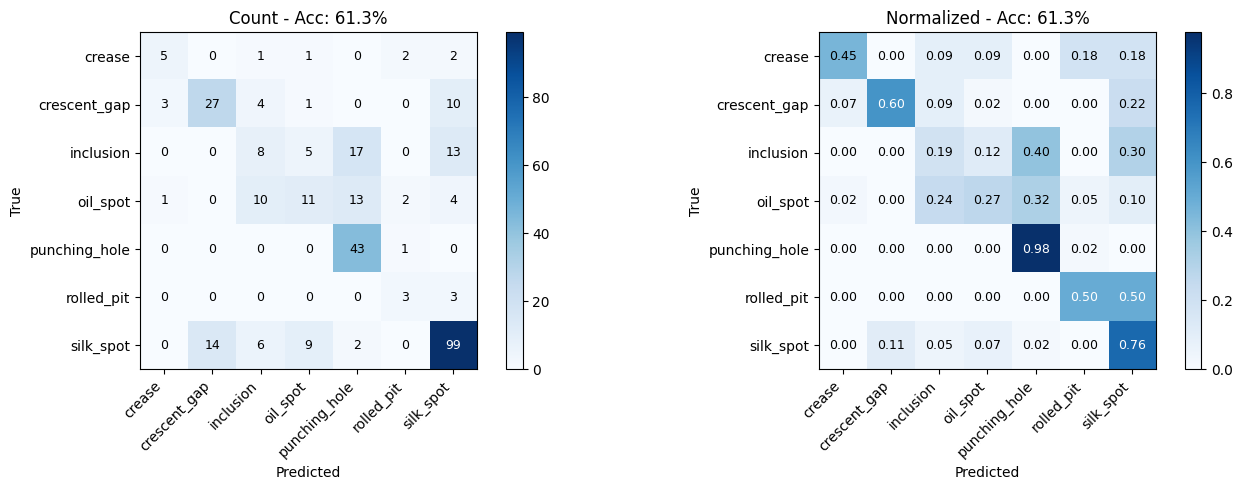

In [60]:
# Eval & confusion matrix
acc = model.evaluate({'image': X_img_test, 'location': X_loc_test}, y_test, verbose=0)[1]
cm = tf.math.confusion_matrix(y_test, model.predict({'image': X_img_test, 'location': X_loc_test}, verbose=0).argmax(1), len(CLASSES)).numpy()
cm_norm = cm / np.maximum(cm.sum(1, keepdims=True), 1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
for ax, data, title in [(ax1, cm, 'Count'), (ax2, cm_norm, 'Normalized')]:
    im = ax.imshow(data, cmap='Blues')
    ax.set_xticks(range(len(CLASSES))); ax.set_yticks(range(len(CLASSES)))
    ax.set_xticklabels(CLASSES, rotation=45, ha='right')
    ax.set_yticklabels(CLASSES)
    ax.set_xlabel('Predicted'); ax.set_ylabel('True')
    ax.set_title(f'{title} - Acc: {acc:.1%}')
    for i in range(len(CLASSES)):
        for j in range(len(CLASSES)):
            ax.text(j, i, f'{data[i,j]:.0f}' if title=='Count' else f'{data[i,j]:.2f}',
                   ha='center', va='center', color='white' if data[i,j]>data.max()/2 else 'black', fontsize=9)
    plt.colorbar(im, ax=ax)
plt.tight_layout(); plt.show()


In [61]:
model.save('defect_classifier_model.keras')
